In [31]:
import tensorcircuit as tc
import numpy as np
from itertools import product
from scipy.optimize import least_squares
from noise_sim_tc import noise_sim

# 1. Test noise_sim

In [32]:

from tensorcircuit.channels import amplitudedampingchannel

# 从 txt 文件读取电路

qubit_num = 6 # 我们读取一个 6 qubit 的 Ising model 的演化电路. 

with open("openqasm_str.txt", "r", encoding="utf-8") as f:
    openqasm_str = f.read()

print("电路: ", openqasm_str)

# 转换为 tc 格式的电路并且输出
c_mat = tc.densitymatrix.DMCircuit.from_openqasm(openqasm_str)
print("noise-free circuit expectation:", c_mat.expectation_ps(z=[windex for windex in range(qubit_num)]))
c_mat.draw()

c_mat_noise = noise_sim(c_mat)
print("noiseless circuit expectation:", c_mat.expectation_ps(z=[windex for windex in range(qubit_num)]))
print("noisy circuit expectation:", c_mat_noise.expectation_ps(z=[windex for windex in range(qubit_num)]))

电路:  OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
h q[1];
cz q[0],q[1];
h q[1];
rz(-1.5707963267948966) q[1];
h q[1];
cz q[0],q[1];
h q[1];
h q[2];
cz q[1],q[2];
h q[2];
rz(-1.5707963267948966) q[2];
h q[2];
cz q[1],q[2];
h q[2];
h q[3];
cz q[2],q[3];
h q[3];
rz(-1.5707963267948966) q[3];
h q[3];
cz q[2],q[3];
h q[3];
h q[4];
cz q[3],q[4];
h q[4];
rz(-1.5707963267948966) q[4];
h q[4];
cz q[3],q[4];
h q[4];
h q[5];
cz q[4],q[5];
h q[5];
rz(-1.5707963267948966) q[5];
h q[5];
cz q[4],q[5];
h q[5];
h q[0];
cz q[5],q[0];
h q[0];
rz(-1.5707963267948966) q[0];
h q[0];
cz q[5],q[0];
h q[0];
rx(0.1) q[0];
rx(0.1) q[1];
rx(0.1) q[2];
rx(0.1) q[3];
rx(0.1) q[4];
rx(0.1) q[5];
h q[1];
cz q[0],q[1];
h q[1];
rz(-1.5707963267948966) q[1];
h q[1];
cz q[0],q[1];
h q[1];
h q[2];
cz q[1],q[2];
h q[2];
rz(-1.5707963267948966) q[2];
h q[2];
cz q[1],q[2];
h q[2];
h q[3];
cz q[2],q[3];
h q[3];
rz(-1.5707963267948966) q[3];
h q[3];
cz q[2],q[3];
h q[3];
h q[4];
cz q[3],q[4];
h q[4];
rz(-1.5707963267948966) 

In [59]:
c = tc.densitymatrix.DMCircuit(2)
c.x(1)
c.cz(0, 1)
c_noised_whole = noise_sim(c)
print("noiseless circuit expectation:", c.expectation_ps(z=[0,1]))
print("noisy whole circuit expectation:", c_noised_whole.expectation_ps(z=[0,1]))

noiseless circuit expectation: (-1+0j)
noisy whole circuit expectation: (-0.7968033+0j)


# 2. Functions

## 2.1. Prepare initial states

In [34]:
def prepare_pauli_plus_state(c, qubit, idx):
    """
    在量子电路 c 的 qubit 位置制备对应 Pauli 的 +1 本征态
    idx: 0=I, 1=X, 2=Y, 3=Z
    """
    if idx == 0:  # I
        pass
    if idx == 1:  # X
        c.h(qubit)
    elif idx == 2:  # Y
        c.h(qubit)
        c.s(qubit)
    elif idx == 3:  # Z
        pass  

def prepare_pauli_word_plus_state(pauli_indices):
    """
    给定 Pauli word 的索引列表，例如 [0, 1, 2] = I⊗X⊗Y
    返回 TensorCircuit 对应制备电路
    """
    n = len(pauli_indices)
    c = tc.densitymatrix.DMCircuit(n)
    for qubit, idx in enumerate(pauli_indices):
        prepare_pauli_plus_state(c, qubit, idx)
    return c

# 示例：I ⊗ X ⊗ Y
pauli_indices = [0, 1, 2]
c = prepare_pauli_word_plus_state(pauli_indices)

print("Circuit:")
print(c)

# 得到状态向量
state = c.state()
print("\nStatevector:")
print(state)


Circuit:

Statevector:
[[0.24999997+0.j         0.        -0.24999997j 0.24999997+0.j
  0.        -0.24999997j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.24999997j 0.24999997+0.j         0.        +0.24999997j
  0.24999997+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.24999997+0.j         0.        -0.24999997j 0.24999997+0.j
  0.        -0.24999997j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.24999997j 0.24999997+0.j         0.        +0.24999997j
  0.24999997+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j       

## 2.2. Pauli words after Clifford conjugation

In [35]:
# 把Pauli word从Epsilon和U(CZ)中间挪到U（CZ)后

# 单比特 Pauli
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
paulis = [I, X, Y, Z]
labels = ['I', 'X', 'Y', 'Z']

# CZ gate
CZ = np.diag([1,1,1,-1]).astype(complex)

def pauli_word(a, b):
    return np.kron(paulis[a], paulis[b])

# === 预计算映射表 ===
mapping = {}
for c, d in product(range(4), repeat=2):  # 遍历 Pm
    Pm = pauli_word(c, d)
    Pn_mat = CZ @ Pm @ CZ
    for a, b in product(range(4), repeat=2):  # 遍历 Pn
        Pw = pauli_word(a, b)
        if np.allclose(Pn_mat, Pw):
            mapping[(a, b)] = (c, d, +1)
        elif np.allclose(Pn_mat, -Pw):
            mapping[(a, b)] = (c, d, -1)

def find_m_for_given_n(a, b):
    """O(1) 查表"""
    return mapping.get((a, b))

# === 示例 ===
a, b = 3, 2  # n = X ⊗ Y
c, d, phase = find_m_for_given_n(a, b)
print(f"n = {labels[a]}⊗{labels[b]}, m = {labels[c]}⊗{labels[d]}, phase={phase}")
print("CZ0,1+ P_n CZ0,1 = Pm")
print(f"CZ0,1+ {labels[a]}⊗{labels[b]} CZ0,1 = {labels[c]}⊗{labels[d]}")
Pn=pauli_word(a, b)
Pm=pauli_word(c, d)
print(CZ @ Pn @ CZ == phase*Pm)


n = Z⊗Y, m = I⊗Y, phase=1
CZ0,1+ P_n CZ0,1 = Pm
CZ0,1+ Z⊗Y CZ0,1 = I⊗Y
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


## 2.3. Solve f(List) from fij(Matrix)

In [36]:
def solve_flist(fab_obs, mask):
    """
    输入:
      fab_obs: (n,m) array, 观测值（缺失位置可以任意）
      mask: bool array same shape, True 表示该位置有观测
    返回:
      fa (len n), fb (len m)
    备注:
      通过最小化残差 log(fab_ij) - (x_i + y_j) 来拟合 x,y，再 exp 得到 fa, fb。
      固定 x0 = 0 来去除平移自由度。
    """
    fab_obs = np.asarray(fab_obs, dtype=float)
    mask = np.asarray(mask, dtype=bool)
    if not np.all(fab_obs[mask] > 0):
        raise ValueError("Observed entries must be > 0 for log-linear method.")
    n, m = fab_obs.shape
    M = np.zeros_like(fab_obs)
    M[mask] = np.log(fab_obs[mask])

    # unknowns: x_rest (n-1) and y (m)
    def residuals(vars):
        x_rest = vars[:n-1]
        y = vars[n-1:]
        x = np.concatenate(([0.0], x_rest))
        # full predicted matrix in log-domain
        pred = x[:, None] + y[None, :]
        # return residuals only at observed entries
        return (pred - M)[mask].ravel()

    init = np.zeros((n-1) + m)
    sol = least_squares(residuals, init, method="trf")
    x_rest = sol.x[:n-1]
    y = sol.x[n-1:]
    x = np.concatenate(([0.0], x_rest))
    # fa=fb
    fa = np.exp(x)
    fb = np.exp(y)
    return fa



In [37]:
# ===== 测试 solve_flist =====
def test_solve_flist():
    np.random.seed(42)

    # 真实 fa, fb
    true_fa = np.array([1.2, 0.9, 1.5])
    true_fb = np.array([0.8, 1.1, 1.3, 0.95])

    # 构造 fab_true
    fab_true = np.outer(true_fa, true_fb)

    # 随机缺失
    mask = np.random.rand(*fab_true.shape) > 0.2  # 80% 概率保留
    # 噪声
    noise = np.random.normal(scale=0.02, size=fab_true.shape)
    fab_obs = fab_true * (1 + noise)

    # 调用求解
    fa_est = solve_flist(fab_obs, mask)

    # 归一化到与真实值同一比例（这里用 fa[0] 对齐）
    scale = true_fa[0] / fa_est[0]
    fa_est_scaled = fa_est * scale

    # 打印结果
    print("真实 fa:", true_fa)
    print("估计 fa:", np.round(fa_est_scaled, 4))
    print("缺失比例:", 1 - mask.mean())

# 运行测试
test_solve_flist()

真实 fa: [1.2 0.9 1.5]
估计 fa: [1.2    0.9017 1.4827]
缺失比例: 0.33333333333333337


## 2.4. Fidelity

In [38]:
# 不能用tc.Circuit(n, inputs=)具体的inputs应该通过|00...0>构造
# 不能用append
def cz_fidelity(observable, n_cz, isNoisy=True):
    """
    observable: list, e.g. [0,3]，0,1,2,3分别代表I,X,Y,Z，顺序对应比特0和1
    n_cz: int, CZ门数量
    返回有噪声电路的期望值
    """
    # 泡利算符映射
    pauli_keys = ['i', 'x', 'y', 'z']
    obs_dict = {pauli_keys[observable[0]]: [0], pauli_keys[observable[1]]: [1]}

    # 生成泡利算符列表
    pauli_dict = {
        'i': np.array([[1, 0], [0, 1]]),
        'x': np.array([[0, 1], [1, 0]]),
        'y': np.array([[0, -1j], [1j, 0]]),
        'z': np.array([[1, 0], [0, -1]])
    }
    # 生成泡利门列表
    pauli_gate_funcs = [lambda c, q: None,  # I门不操作
                lambda c, q: c.x(q),
                lambda c, q: c.y(q),
                lambda c, q: c.z(q)]
    

    # ================================================================================================
    # # （有 噪声前后的泡利算符），适用于将非pauli噪声转换成泡利噪声
    #     # CZ 门和带有噪声模拟的CZ门
    #     circuit_cz= tc.Circuit(2)
    #     circuit_cz.cz(0, 1)
    #     circuit_noise = noise_sim(circuit_cz)

    # # 构造电路
    # expectation_sum = 0
    # for i in range(4):
    #     for j in range(4):
    #         #已经定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    #         circuit = prepare_pauli_word_plus_state(observable) 
    #         # pauli算符(噪声门前)
    #         circuit_before_channel = tc.Circuit(2)
    #         pauli_gate_funcs[i](circuit_before_channel, 0)
    #         pauli_gate_funcs[j](circuit_before_channel, 1)
    #         # pauli算符(噪声门后)   
    #         circuit_after_channel = tc.Circuit(2)
    #         cz_i, cz_j, phase = find_m_for_given_n(i, j)
    #         pauli_gate_funcs[cz_i](circuit_after_channel, 0)
    #         pauli_gate_funcs[cz_j](circuit_after_channel, 1)
            
    #         # 构建电路
    #         for _ in range(n_cz):
    #             # 添加泡利算符(噪声前)
    #             circuit.append(circuit_before_channel)
    #             # 添加CZ门或者带有噪声模拟的CZ门
    #             if isNoisy:
    #                 circuit.append(circuit_noise)
    #             else:
    #                 circuit.append(circuit_cz)
    #             # 添加泡利算符(噪声后)
    #             circuit.append(circuit_after_channel)
                
    #         # 计算期望值
    #         expectation_sum+=circuit.expectation_ps(**obs_dict) 
    # return expectation_sum / (4**2) 
    

    # ================================================================================================
    # （无 噪声前后的泡利算符），适用noise channel本身就是pauli的情况
    # 构造电路
    # circuit = tc.densitymatrix.DMCircuit(2)
    c = prepare_pauli_word_plus_state(observable) #已经定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    for _ in range(n_cz):
        c.cz(0, 1)
    c = noise_sim(c) if isNoisy else c
    # 计算期望值
    expectation = c.expectation_ps(**obs_dict)
    return expectation

In [39]:
# noiseless fidelities(should all be 1)

f_noiseless=[]
for i in range(4):
    for j in range(4):
        fidelity2_ij = cz_fidelity([i,j], n_cz=2, isNoisy=False)
        fidelity4_ij = cz_fidelity([i,j], n_cz=4, isNoisy=False)
        if fidelity2_ij == 0:
            f_noiseless.append(0)
        else:
            f_noiseless.append(fidelity4_ij / fidelity2_ij)
print(f_noiseless)

[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]


In [40]:
# fidelities with noise
observable=[3,3]
result = cz_fidelity(observable, n_cz=2,isNoisy=False)
result_1 = cz_fidelity(observable, n_cz=2,isNoisy=True)
result_2 = cz_fidelity(observable, n_cz=4,isNoisy=True)
result_3 = cz_fidelity(observable, n_cz=20,isNoisy=True)
print(result, result_1, result_2, result_3)

(1+0j) (0.63744265+0j) (0.40633312+0j) (0.011076629+0j)


# 3. Learn Noise of CZ gate

## 3.1. Get fidelity matrix

In [41]:
# Initialize storage
fij_matrix = np.zeros((16, 16), dtype=float)  # 4x4 矩阵存储 fidelity4_ij / fidelity2_ij 的实部
# fij_matrix的行代表(ij)_4,列代表(cz_i,cz_j)_4，_4表示四进制，需要转换成十进制
# 列也就是U作用于Fij的结构（也是一个pauli word）的index
mask = np.zeros((16, 16), dtype=bool)    # 初始元素都是False

# Iterate over all Pauli observables [i,j]
for i in range(4):
    for j in range(4):
        fidelity2_ij = cz_fidelity([i, j], n_cz=2, isNoisy=True)
        fidelity4_ij = cz_fidelity([i, j], n_cz=4, isNoisy=True)
        ratio = (fidelity4_ij / fidelity2_ij).real
        
        # 计算在 f_noisy 中的位置
        pos_row = i * 4 + j  
        cz_i, cz_j, phase = find_m_for_given_n(i, j)
        pos_col = cz_i * 4 + cz_j

        # U(Pa)=Pb，不能有相位差(phase=-1)
        if phase == 1:
            fij_matrix[pos_row, pos_col] = ratio
            mask[pos_row, pos_col] = True        # 填充矩阵

        # 处理特殊情况,第二个pauli word为X(j=1)等价于第二个pauli word为Z(j=3)
        if j == 3:
            j = 1
            pos_row = i * 4 + j  
            cz_i, cz_j, phase = find_m_for_given_n(i, j)
            pos_col = cz_i * 4 + cz_j
            fij_matrix[pos_row, pos_col] = ratio
            mask[pos_row, pos_col] = True        # 填充矩阵
        elif j == 1:
            j = 3
            pos_row = i * 4 + j  
            cz_i, cz_j, phase = find_m_for_given_n(i, j)
            pos_col = cz_i * 4 + cz_j
            fij_matrix[pos_row, pos_col] = ratio
            mask[pos_row, pos_col] = True        # 填充矩阵

print("\nFidelity ratios (fij_list, real parts only):")
print(fij_matrix)
print("\nMissing entries (True if fidelity2_ij == 0):")
print(mask)


Fidelity ratios (fij_list, real parts only):
[[1.00000012 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.63744265 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.63362056 0.        ]
 [0.         0.         0.         0.63744265 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.79520977 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.79520977 0.

## 3.2. Get fidelity list

In [42]:
f_list = solve_flist(fij_matrix, mask)
print(f_list)

[1.         0.79840005 0.79600286 0.79840005 0.89174535 0.89174535
 1.         0.89174535 0.88995828 0.88995828 0.79600286 0.88995828
 0.99800008 0.79840005 0.79600286 0.79840005]


## 3.2. Get w_k

In [43]:
# Define the size and labels for two-qubit Pauli operators (4x4=16)
pauli_labels = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

# Initialize the 16x16 matrix M with zeros
M = np.zeros((16, 16), dtype=int)

# Fill the matrix M based on Pauli commutation relations
for i in range(16):
    for j in range(16):
        # Decompose indices into qubit components (q1, q2)
        q1_i, q2_i = divmod(i, 4)
        q1_j, q2_j = divmod(j, 4)
        
        # Check commutation on each qubit
        comm_q1 = 0 if (q1_i == 0 or q1_j == 0 or q1_i == q1_j) else 1
        comm_q2 = 0 if (q2_i == 0 or q2_j == 0 or q2_i == q2_j) else 1
        
        # Operators anti-commute if odd number of anti-commuting qubits
        M[i, j] = (comm_q1 + comm_q2) % 2

# Compute the pseudoinverse M_plus = (1/8) * M
M_plus = M / 8.0

# Print M_plus with row and column labels
print("Pseudoinverse matrix M_plus:")
print("       " + " ".join(f"{label:>6}" for label in pauli_labels))
for i, label in enumerate(pauli_labels):
    row_str = " ".join(f"{val:6.3f}" for val in M_plus[i])
    print(f"{label}: {row_str}")

Pseudoinverse matrix M_plus:
           II     IX     IY     IZ     XI     XX     XY     XZ     YI     YX     YY     YZ     ZI     ZX     ZY     ZZ
II:  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
IX:  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125
IY:  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125
IZ:  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.000
XI:  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125
XX:  0.000  0.000  0.125  0.125  0.000  0.000  0.125  0.125  0.125  0.125  0.000  0.000  0.125  0.125  0.000  0.000
XY:  0.000  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.125  0.000  0.125  0.000  0.125  0.000  0.125  0.000
XZ:  0.000  0.125  0.125  0.000  0.000  

In [44]:
lam = M_plus @ (-np.log(f_list)/2)
w = (1 + np.exp(-2 * lam)) / 2 
print(w)

[1.         0.92152122 0.92167991 0.92152122 0.92722705 0.93969681
 0.92744136 0.93969681 0.93991737 0.92744136 0.93969681 0.92744136
 0.94559291 0.92136303 0.92183822 0.92136303]


# 施加噪声n次

In [ ]:
def expectation_n_noisy_channel_cz(observable=[3,3], n_noise=1):
    # observable = [3,3]默认输出zz基下的期望值
    # n_noise: int, 噪声channel层数
    # 泡利算符映射
    pauli_keys = ['i', 'x', 'y', 'z']
    obs_dict = {pauli_keys[observable[0]]: [0], pauli_keys[observable[1]]: [1]}

    # 生成泡利算符列表
    pauli_dict = {
        'i': np.array([[1, 0], [0, 1]]),
        'x': np.array([[0, 1], [1, 0]]),
        'y': np.array([[0, -1j], [1j, 0]]),
        'z': np.array([[1, 0], [0, -1]])
    }
    # 生成泡利门列表
    pauli_gate_funcs = [lambda c, q: None,  # I门不操作
                lambda c, q: c.x(q),
                lambda c, q: c.y(q),
                lambda c, q: c.z(q)]
    
    #定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    c = prepare_pauli_word_plus_state(observable)
    # 在for循环后的cz门已经是带有噪声的了，所以如果不随即加入pauli word门，则噪声只作用于最后的cz门，相当于n_noise=1
    # 因此for循环的次数为n_noise-1
    for _ in range(n_noise-1):
        for i in range(4):
            for j in range(4):
                n = 4*i+j
                rand = np.random.rand()
                if rand > w[n]: #以(1-w[n])的概率施加pauli word门，表示噪声
                    pauli_gate_funcs[i](c, 0)
                    pauli_gate_funcs[j](c, 1)
    # 添加 CZ 门
    c.cz(0, 1)
    # 添加噪声,虽然看起来对所有门（包括pauli words）都添加了噪声，但实际上噪声只作用于 CZ 门（因为噪声模拟器只作用于2比特门）
    if n_noise >= 1:
        c = noise_sim(c)  
    else:
        pass
    # 计算期望值
    return c.expectation_ps(**obs_dict)

In [ ]:
simu_num = 50 # 每个n_noise的模拟次数,由于noise的产生是pauli word gate以一定概率在电路中出现，因此需要多次模拟取平均
expectation_n_noisy_channel_cz_list = []
for n in range(1, 21):
    expectation_avg = 0
    for _ in range(simu_num):
        expectation = expectation_n_noisy_channel_cz(n_noise=n)
        expectation_avg += expectation / simu_num
    expectation_n_noisy_channel_cz_list.append(expectation_avg)
    print(f"n={n}, expectation={expectation_avg}")

n=1, expectation=(0.7984000444412225+0j)
n=2, expectation=(0.2874240159988403+0j)
n=3, expectation=(-0.06387200355529785+0j)
n=4, expectation=(-0.03193600177764892+0j)
n=5, expectation=(-0.19161601066589357+0j)
n=6, expectation=(0.15968000888824466+0j)
n=7, expectation=(-0.03193600177764892+0j)
n=8, expectation=(-0.06387200355529785+0j)
n=9, expectation=0j
n=10, expectation=(-0.15968000888824466+0j)
n=11, expectation=(-0.03193600177764892+0j)
n=12, expectation=(-0.15968000888824466+0j)
n=13, expectation=(-0.03193600177764892+0j)
n=14, expectation=(0.06387200355529785+0j)
n=15, expectation=(0.09580800533294678+0j)
n=16, expectation=(0.2235520124435425+0j)
n=17, expectation=(-0.09580800533294678+0j)
n=18, expectation=(0.03193600177764892+0j)
n=19, expectation=(-0.06387200355529785+0j)
n=20, expectation=0j


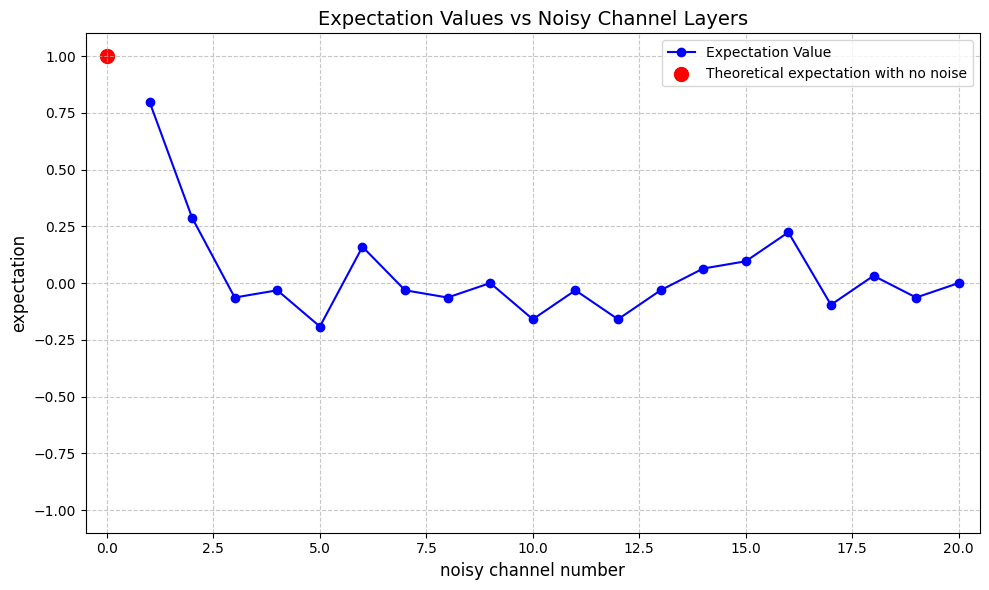

In [98]:
import matplotlib.pyplot as plt

# 生成横轴数据 (index+1)
x_values = [i+1 for i in range(len(expectation_n_noisy_channel_cz_list))]
y_values = np.real(expectation_n_noisy_channel_cz_list)

# 创建图表
plt.figure(figsize=(10, 6))  # 设置图表大小

# 绘制折线图
plt.plot(x_values, y_values, 
         marker='o', linestyle='-', color='b', label='Expectation Value')

# 添加红色点 (0, 1)
theor_exp = np.real(expectation_n_noisy_channel_cz(observable=[3,3], n_noise=0))
plt.scatter(0, theor_exp, color='red', s=100, label='Theoretical expectation with no noise')

# 设置坐标轴范围
plt.xlim(-0.5, max(x_values)+0.5)  # 让x=0的点可见
plt.ylim(-1.1, 1.1)  # y轴固定在-1到1

# 添加标题和标签
plt.title('Expectation Values vs Noisy Channel Layers', fontsize=14)
plt.xlabel('noisy channel number', fontsize=12)
plt.ylabel('expectation', fontsize=12)

# 添加网格和标签
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 自动调整布局
plt.tight_layout()

# 显示图表
plt.show()